In [1]:
import warnings
warnings.filterwarnings('ignore') # to suppress some matplotlib deprecation warnings

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import ast
import cv2

import matplotlib.pyplot as plt
import matplotlib.style as style

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import glob
import time
import tqdm

In [2]:
!nvidia-smi

Sat Dec  1 13:47:08 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.72       Driver Version: 410.72       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    34W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import torchvision
from torchvision import transforms, utils


In [4]:
en_dict = {}
path = '/home/nazim/quickdraw/train'

filenames = glob.glob(os.path.join(path, '*.csv'))
filenames = sorted(filenames)

def encode_files():
    """ Encode all label by name of csv_files """
    counter = 0
    for fn in filenames:
        en_dict[fn[:-4].split('/')[-1].replace(' ', '_')] = counter
        counter += 1
        
# collect file names and encode label
encode_files()

dec_dict = {v: k for k, v in en_dict.items()}
def decode_labels(label):
    return dec_dict[label]

def get_label(nfile):
    """ Return encoded label for class by name of csv_files """
    return en_dict[nfile.replace(' ', '_')[:-4]]


In [5]:
class DoodlesDataset(Dataset):
    """Doodles csv dataset."""

    def __init__(self, csv_file, root_dir, mode='train', nrows=1000, skiprows=None, size=256, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            mode (string): Train or test mode.
            nrows (int): Number of rows of file to read. Useful for reading pieces of large files.
            skiprows (list-like or integer or callable): 
                    Line numbers to skip (0-indexed) or number of lines to skip (int) at the start of the file.
            size (int): Size of output image.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        file = os.path.join(self.root_dir, csv_file)
        self.size = size
        self.mode = mode
        if self.mode == 'train':
            mypd = pd.read_csv(file, nrows=nrows)#, skiprows=skiprows)
            x = mypd['countrycode']
            p=[i+1 for i,y in enumerate(x) if y != 'AU']
            self.doodle = pd.read_csv(file, usecols=['drawing'], nrows=nrows, skiprows=p)
        if self.mode == 'test':
            self.doodle = pd.read_csv(file, usecols=['drawing'], nrows=nrows, skiprows=skiprows)
        self.transform = transform
        if self.mode == 'train':
            self.label = get_label(csv_file)

    @staticmethod
    def _draw(raw_strokes, size=256, lw=2, time_color=True):
        BASE_SIZE = 256
        img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
        for t, stroke in enumerate(raw_strokes):
            for i in range(len(stroke[0]) - 1):
                color = 255 - min(t, 10) * 13 if time_color else 255
                _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                             (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
        if size != BASE_SIZE:
            return cv2.resize(img, (size, size))
        else:
            return img
    
    def __len__(self):
        return len(self.doodle)

    def __getitem__(self, idx):
        raw_strokes = ast.literal_eval(self.doodle.drawing[idx])
        sample = self._draw(raw_strokes, size=self.size, lw=2, time_color=True)
        if self.transform:
            sample = self.transform(sample)
        if self.mode == 'train':
            return (sample[None]/255).astype('float32'), self.label
        else:
            return (sample[None]/255).astype('float32')

In [6]:
SIZE = 224 # for matching to imagenet
# collect all single csvset in one

In [7]:
select_nrows = 1500
doodle_all = ConcatDataset([DoodlesDataset(fn.split('/')[-1], path, 
                                           nrows=select_nrows, size=SIZE) for fn in filenames])

In [8]:


# select some rows for validation
# valid_rows = 100
# validationset = ConcatDataset([DoodlesDataset(fn.split('/')[-1], path, nrows=valid_rows, size=SIZE,
#                                            skiprows=range(1, select_nrows+1)) for fn in filenames])



In [9]:
# total images in set
print('Train set:', len(doodle_all))
# print('Validation set:', len(validationset))
# Use the torch dataloader to iterate through the dataset
loader = DataLoader(doodle_all, batch_size=int(128), shuffle=True, num_workers=0)
# valid_loader = DataLoader(validationset, batch_size=128, shuffle=False, num_workers=0)



Train set: 340000


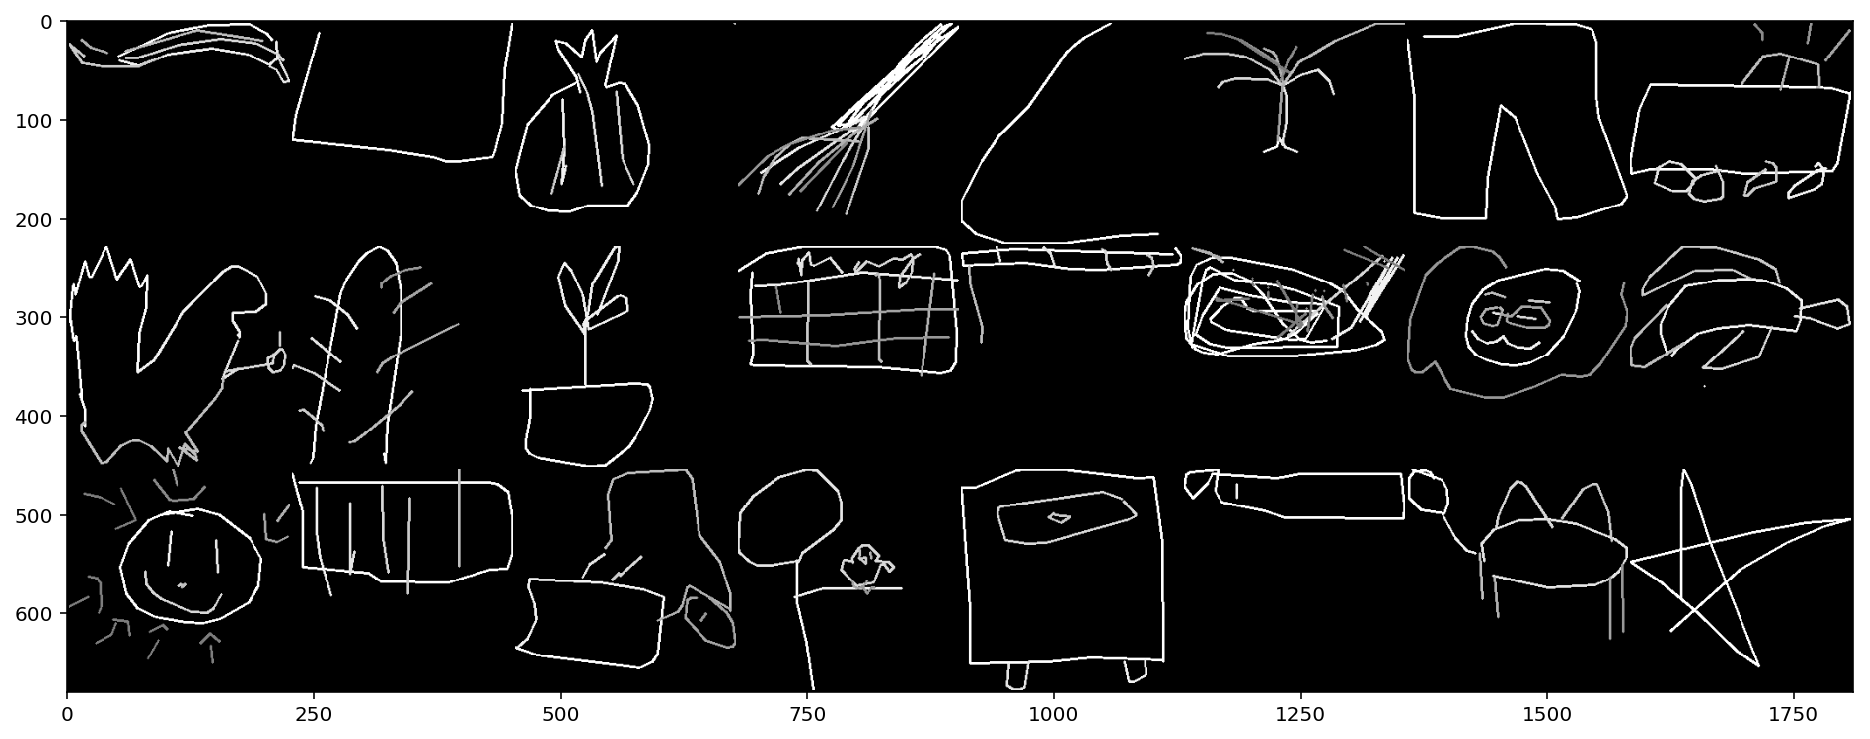

In [10]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some images
dataiter = iter(loader)
images, label = dataiter.next()

# show images
plt.figure(figsize=(16,24))
imshow(torchvision.utils.make_grid(images[:24]))

In [11]:
# validation function 
def validation(lossf, scoref):
    model.eval()
    loss, score = 0, 0
    vlen = len(valid_loader)
    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss += lossf(output, y).item()
        score += scoref(output, y)[0].item()
    model.train()
    return loss/vlen, score/vlen


In [12]:
def accuracy(output, target, topk=(3,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


In [13]:
def mapk(output, target, k=3):
    """
    Computes the mean average precision at k.
    
    Parameters
    ----------
    output (torch.Tensor): A Tensor of predicted elements.
                           Shape: (N,C)  where C = number of classes, N = batch size
    target (torch.int): A Tensor of elements that are to be predicted. 
                        Shape: (N) where each value is  0≤targets[i]≤C−1
    k (int, optional): The maximum number of predicted elements
    
    Returns
    -------
    score (torch.float):  The mean average precision at k over the output
    """
    with torch.no_grad():
        batch_size = target.size(0)

        _, pred = output.topk(k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        for i in range(k):
            correct[i] = correct[i]*(k-i)
            
        score = correct[:k].view(-1).float().sum(0, keepdim=True)
        score.mul_(1.0 / (k * batch_size))
        return score

In [14]:
# model = torchvision.models.resnet34(pretrained=True)

In [15]:
# import pretrainedmodels

In [15]:
# print(pretrainedmodels.model_names)

In [16]:
# model_name = 'se_resnext101_32x4d'
# model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')

In [18]:
# model.layer0.conv1

In [19]:
# # Chenge number of inputs channels and number of classes 
# # Its first and last layers in model
# def squeeze_weights(m):
#         m.weight.data = m.weight.data.sum(dim=1)[:,None]
#         m.in_channels = 1
        
# model.layer0.conv1.apply(squeeze_weights);#densenet161
# # model.features[0].apply(squeeze_weights);
# num_classes = 340
# model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)



In [20]:
# %%time
# # test with random data
# model(torch.randn(12,1,224,224)).size()

In [21]:
model=torch.load('se_resnext101_32x4d_EG_7k.pth')

In [22]:
device = 'cuda'
model.to(device);

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, amsgrad=True)

In [24]:
# PyTorch scheduler:
# https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000,2000,int(3000),6000,int(12000),18000,20000], gamma=0.5)

In [25]:
from apex.apex import amp
amp_handle = amp.init()

In [26]:
%%time
epochs = 1
lsize = len(loader)
itr = 1
p_itr = 100 # print every N iteration
model.train()
tloss, score = 0, 0
for epoch in range(epochs):
    for x, y in tqdm.tqdm(loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
#         loss.backward()
        with amp_handle.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        optimizer.step()
        tloss += loss.item()
        score += mapk(output, y)[0].item()
        scheduler.step()
        if itr%p_itr==0:
#             vloss, vscore = validation(criterion, mapk)
            print('Iteration {} -> Train Loss: {:.4f}, MAP@3: {:.3f}'.format(itr, tloss/p_itr, score/p_itr))
#             print('Iteration {} -> Validation Loss: {:.4f}, MAP@3: {:.3f}'.format(itr, vloss, vscore))
#             scheduler.step(vscore)
#             time.sleep(0.1)
            tloss, score = 0, 0
        itr +=1
# vloss, vscore = validation(criterion, mapk)
itr = itr%p_itr
print('Final -> Loss: {:.4f}, MAP@3: {:.3f}'.format(loss/itr, score/itr))


  4%|▍         | 100/2657 [02:38<1:07:36,  1.59s/it]

Iteration 100 -> Train Loss: 0.7241, MAP@3: 0.882


  8%|▊         | 200/2657 [05:15<1:04:39,  1.58s/it]

Iteration 200 -> Train Loss: 0.6988, MAP@3: 0.887


 11%|█▏        | 300/2657 [07:53<1:02:13,  1.58s/it]

Iteration 300 -> Train Loss: 0.7084, MAP@3: 0.884


 15%|█▌        | 400/2657 [10:30<59:07,  1.57s/it]

Iteration 400 -> Train Loss: 0.7108, MAP@3: 0.886


 19%|█▉        | 500/2657 [13:08<56:49,  1.58s/it]

Iteration 500 -> Train Loss: 0.7091, MAP@3: 0.885


 23%|██▎       | 600/2657 [15:46<54:01,  1.58s/it]

Iteration 600 -> Train Loss: 0.6752, MAP@3: 0.889


 26%|██▋       | 700/2657 [18:23<51:30,  1.58s/it]

Iteration 700 -> Train Loss: 0.6844, MAP@3: 0.887


 30%|███       | 800/2657 [21:01<49:10,  1.59s/it]

Iteration 800 -> Train Loss: 0.7132, MAP@3: 0.883


 34%|███▍      | 900/2657 [23:39<46:18,  1.58s/it]

Iteration 900 -> Train Loss: 0.6671, MAP@3: 0.890


 38%|███▊      | 1000/2657 [26:17<43:39,  1.58s/it]

Iteration 1000 -> Train Loss: 0.6934, MAP@3: 0.887


 41%|████▏     | 1100/2657 [28:55<41:00,  1.58s/it]

Iteration 1100 -> Train Loss: 0.7068, MAP@3: 0.886


 45%|████▌     | 1200/2657 [31:33<38:11,  1.57s/it]

Iteration 1200 -> Train Loss: 0.6964, MAP@3: 0.886


 49%|████▉     | 1300/2657 [34:10<35:42,  1.58s/it]

Iteration 1300 -> Train Loss: 0.6897, MAP@3: 0.888


 53%|█████▎    | 1400/2657 [36:49<33:13,  1.59s/it]

Iteration 1400 -> Train Loss: 0.7164, MAP@3: 0.886


 56%|█████▋    | 1500/2657 [39:26<30:29,  1.58s/it]

Iteration 1500 -> Train Loss: 0.6929, MAP@3: 0.890


 60%|██████    | 1600/2657 [42:04<27:54,  1.58s/it]

Iteration 1600 -> Train Loss: 0.6999, MAP@3: 0.886


 64%|██████▍   | 1700/2657 [44:43<25:20,  1.59s/it]

Iteration 1700 -> Train Loss: 0.7114, MAP@3: 0.886


 68%|██████▊   | 1800/2657 [47:20<22:09,  1.55s/it]

Iteration 1800 -> Train Loss: 0.6687, MAP@3: 0.891


 72%|███████▏  | 1900/2657 [49:56<19:35,  1.55s/it]

Iteration 1900 -> Train Loss: 0.6852, MAP@3: 0.889


 75%|███████▌  | 2000/2657 [52:31<16:52,  1.54s/it]

Iteration 2000 -> Train Loss: 0.6844, MAP@3: 0.888


 79%|███████▉  | 2100/2657 [55:06<14:24,  1.55s/it]

Iteration 2100 -> Train Loss: 0.6945, MAP@3: 0.887


 83%|████████▎ | 2200/2657 [57:41<11:45,  1.54s/it]

Iteration 2200 -> Train Loss: 0.6603, MAP@3: 0.892


 87%|████████▋ | 2300/2657 [1:00:16<09:13,  1.55s/it]

Iteration 2300 -> Train Loss: 0.6903, MAP@3: 0.888


 90%|█████████ | 2400/2657 [1:02:50<06:36,  1.54s/it]

Iteration 2400 -> Train Loss: 0.6975, MAP@3: 0.886


 94%|█████████▍| 2500/2657 [1:05:26<04:05,  1.56s/it]

Iteration 2500 -> Train Loss: 0.6842, MAP@3: 0.889


 98%|█████████▊| 2600/2657 [1:08:02<01:28,  1.56s/it]

Iteration 2600 -> Train Loss: 0.6921, MAP@3: 0.890


100%|██████████| 2657/2657 [1:09:30<00:00,  1.28s/it]

Final -> Loss: 0.0107, MAP@3: 0.872
CPU times: user 51min 20s, sys: 18min 12s, total: 1h 9min 32s
Wall time: 1h 9min 30s


In [ ]:
!nvidia-smi0

In [ ]:
#this is py

In [28]:
torch.save(model, "se_resnext101_32x4d_AU_1k_with_EG_weights.pth")

In [ ]:
!nvidia-smi

In [18]:
# model.load_state_dict(torch.load('se_resnext101_32x4d_10k.pth'))

In [19]:
# device = 'cuda'
# model.to(device);

In [ ]:
# torch.save(model, "se_resnext101_32x4d_UK_10k.pth")

In [14]:
model = torch.load('se_resnext101_32x4d_UK_1k.pth')

In [29]:
testset = DoodlesDataset('test_simplified.csv', '/home/nazim/quickdraw', mode='test', nrows=None, size=SIZE)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)

In [30]:
labels = np.empty((0,3))
device = 'cuda'
for x in tqdm.tqdm(testloader):
    x = x.to(device)
    output = model(x)
    _, pred = output.topk(3, 1, True, True)
    labels = np.concatenate([labels, pred], axis = 0)

100%|██████████| 1754/1754 [07:11<00:00,  4.07it/s]


In [ ]:
%%time
submission = pd.read_csv('/home/nazim/quickdraw/test_simplified.csv', index_col='key_id')
submission.drop(['countrycode', 'drawing'], axis=1, inplace=True)
submission['word'] = ''
for i, label in enumerate(labels):
    submission.word.iloc[i] = " ".join([decode_labels(l) for l in label])

In [ ]:
submission.to_csv('se_resnext101_32x4d_AU_1k_with_EG_weights.csv')

In [ ]:
submission.head()